In [1]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from numpy import array, newaxis, expand_dims

Using TensorFlow backend.


In [2]:
%run functions.py

In [3]:
path="/home/seo/ISIC DATA/"
process_path='/home/seo/jupyter/Capstone2'
filelist=os.listdir(path)
processfiles=os.listdir(process_path)
meta=[file for file in filelist if not file.endswith(".jpeg") and not file.endswith(".png") and file.startswith("ISIC")]
pics=[file for file in filelist if (file.endswith(".jpeg") or file.endswith(".png")) and file.startswith("ISIC")]

In [4]:
import pickle
model=pickle.load(open('model_fitted.pickle',"rb"))

W0729 07:14:46.485342 140716798723904 deprecation_wrapper.py:119] From /home/seo/environments/my_env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0729 07:14:46.508061 140716798723904 deprecation_wrapper.py:119] From /home/seo/environments/my_env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0729 07:14:46.539258 140716798723904 deprecation_wrapper.py:119] From /home/seo/environments/my_env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0729 07:14:46.540411 140716798723904 deprecation_wrapper.py:119] From /home/seo/environments/my_env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated

In [8]:
seg_files=[file for file in processfiles if file.split('_')[0]=='seg']


In [6]:
for chunk in seg_files:
    seg_dict_open=pickle.load(open(chunk,'rb'))
    for key in seg_dict_open.keys():
        

SyntaxError: unexpected EOF while parsing (<ipython-input-6-85d214c82ecf>, line 4)

In [9]:
master_dict=dict()
for name in seg_files:
    temp=pickle.load(open(name,'rb'))
    master_dict.update(temp)

In [10]:
len(master_dict)

18975

In [11]:
def symmetry(rotated_roi,contoursize):
    imageO=rotated_roi
    imageLR=np.fliplr(rotated_roi)
    imageUD=np.flipud(rotated_roi)
    #plt.subplot(1,2,1),plt.imshow((imageO.astype("float")-imageLR.astype("float"))**2),plt.title('LR symmetry'),plt.xticks([]),plt.yticks([])
    #plt.subplot(1,2,2),plt.imshow((imageO.astype("float")-imageUD.astype("float"))**2),plt.title('UD symmetry'),plt.xticks([]),plt.yticks([])

    lr=mse(rotated_roi, np.fliplr(rotated_roi),contourSize)
    ud=mse(rotated_roi, np.flipud(rotated_roi),contourSize)
    return lr,ud

In [12]:
sym_dict=dict()
cont_dict=dict()
good_imgs=list()
for key in master_dict.keys():
    sym_check=master_dict[key]
    label='_'.join(key.split('_')[0:2])
    cnts,h=cv2.findContours(sym_check[:,:,0],cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE )
    try:
        cnt=cnts[0]
        M = cv2.moments(cnt)
        (a,b),(MA,ma),angle = cv2.fitEllipse(cnt)
        a=int(a)
        b=int(b)
        contourSize = cv2.contourArea(cnt)
        good_imgs.append(key)
        cont_dict[key]=cnt
    except:
        continue


    rotated_roi1=rotate_bound(sym_check[:,:,0],angle,a,b)
    rotated_roi2=rotate_bound(sym_check[:,:,1],angle,a,b)
    rotated_roi3=rotate_bound(sym_check[:,:,2],angle,a,b)
    lr1,ud1=symmetry(rotated_roi1,contourSize)
    lr2,ud2=symmetry(rotated_roi2,contourSize)
    lr3,ud3=symmetry(rotated_roi3,contourSize)
    lr=np.mean([lr1,lr2,lr3])
    ud=np.mean([ud1,ud2,ud3])
    sym_dict[label]=[lr,ud]
    

/home/seo/jupyter/Capstone2/functions.py:105: RuntimeWarning: divide by zero encountered in double_scalars
  err /= float(contour_size)


In [13]:
blue_dict=dict()
green_dict=dict()
red_dict=dict()
for key in good_imgs:
    colorcheck=master_dict[key]
    label='_'.join(key.split('_')[0:2])
    color = ('b','g','r')
    #fig=plt.figure()
    zerovalues=list()
    #ax=fig.add_subplot(2,1,1)
    for i,col in enumerate(color):
        histr = cv2.calcHist([colorcheck],[i],None,[256],[0,256])
        #ax.plot(histr,color = col)
        zerovalues.append(histr[0])
        histr=histr[1:]
        #plt.xlim([0,255])
        #ax.set_yscale('log')
        if col=='b':
            blue_dict[label]=histr.std()
        if col=='g':
            green_dict[label]=histr.std()
        if col=='r':
            red_dict[label]=histr.std()

In [26]:
border_dict=dict()
for key in good_imgs:
    border_check=master_dict[key]
    cnt=cont_dict[key]
    label='_'.join(key.split('_')[0:2])
    orig_img=label+'.jpeg'
    resized_orig=resize(call_image(path+orig_img), (128, 128, 1), mode = 'constant', 
                  preserve_range = True)
    H,W = resized_orig.shape[:2]
    h=20; w=20
    tots_gradient=[]
    for point in cnt[:,0]:
        x=point[0]
        y=point[1]
        #print(x,y)
        y1=y-h; y2=y+h
        x1=x-w; x2=x+w
        if y1<0:
            y1=0
        if y2>H:
            y2=H
        if x1<0:
            x1=0
        if x2>W:
            x2=W
        #print(x1,y1,x2,y2)
        crop_img = resized_orig.squeeze()[y1:y2, x1:x2].copy()
        mag,ang,gx,gy=get_mag_ang(crop_img)
        tots_gradient.append(mag.mean())
    border_dict[label]=np.mean(tots_gradient)

TypeError: 'NoneType' object is not subscriptable

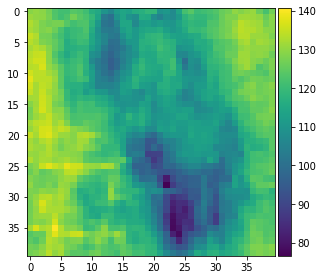

In [25]:
imshow(resized_orig.squeeze()[y1:y2, x1:x2])

In [15]:
pickle.dump(sym_dict, open('symm_1.p',"wb"))

In [16]:
pickle.dump(blue_dict, open('b_1.p',"wb"))
pickle.dump(green_dict, open('g_1.p',"wb"))
pickle.dump(red_dict, open('r_1.p',"wb"))

In [12]:
seg_dict=pickle.load(open('seg_5999.p','rb'))
seg_dict2=pickle.load(open('seg_7999.p','rb'))

In [13]:
seg_dict2

{'ISIC_0008191_segmented': array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8),
 'ISIC_0012397_segmented': array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
    

In [14]:
seg_dict

{'ISIC_0000460_segmented': array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8),
 'ISIC_0004389_segmented': array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
    

In [11]:
seg_dict_open

{'ISIC_0000460_segmented': array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8),
 'ISIC_0004389_segmented': array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
    